In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, f1_score, recall_score
from sklearn.preprocessing import StandardScaler

C:\Users\U0139040\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

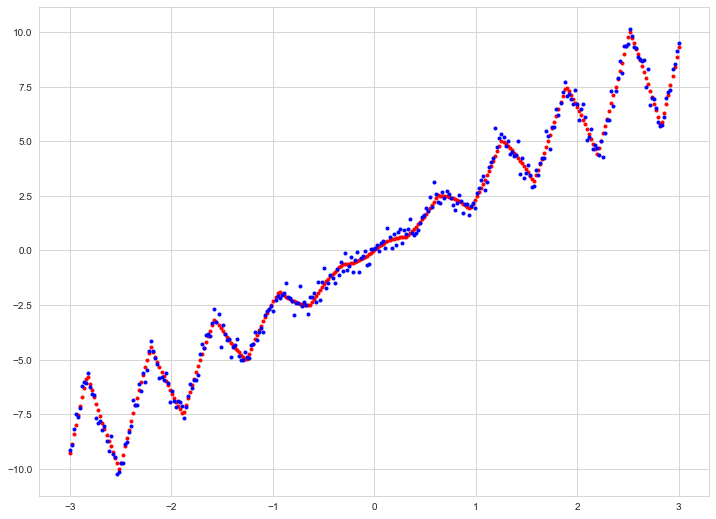

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать

def f(X):
    return (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X

np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = f(X)
plt.plot(X.reshape(-1), y.reshape(-1), "b.", color="red")
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.", color="blue");


In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", label=r"$\hat{y}$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=label)


Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

max_depth=1 depth=1
max_depth=2 depth=2
max_depth=3 depth=3
max_depth=4 depth=4
max_depth=5 depth=5
max_depth=6 depth=6
max_depth=7 depth=7
max_depth=8 depth=8
max_depth=9 depth=9
max_depth=10 depth=10
max_depth=11 depth=11
max_depth=12 depth=12
max_depth=13 depth=13
max_depth=14 depth=13
max_depth=15 depth=13


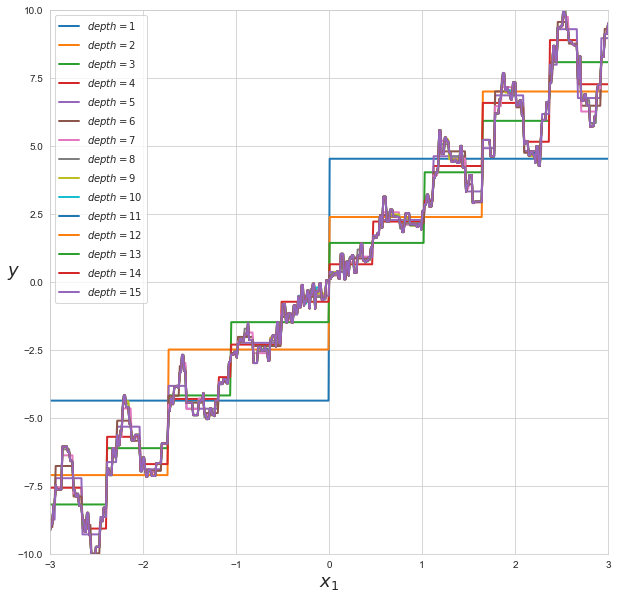

In [6]:
plt.figure(figsize=(10, 10))

for i in range(1, 16):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    clf_reg = DecisionTreeRegressor(max_depth=i, random_state=42)
    clf_reg.fit(X_train, y_train)
    print(f"max_depth={i} depth={clf_reg.get_depth()}")
    plot_regression_predictions(clf_reg, X, y, label=f"$depth={i}$")

plt.legend()
plt.show()

<font size=3 color='royalblue'><b>Маленькие глубины дают плохие результаты, можно отбросить их, чтобы не загромождать график.</b></font>

max_depth=6 depth=6
max_depth=7 depth=7
max_depth=8 depth=8
max_depth=9 depth=9
max_depth=10 depth=10
max_depth=11 depth=11
max_depth=12 depth=12
max_depth=13 depth=13


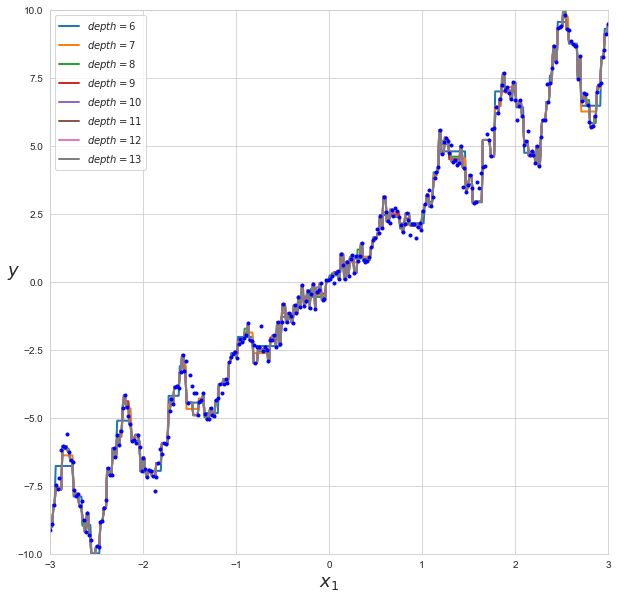

In [7]:
plt.figure(figsize=(10, 10))

for i in range(6, 14):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    clf_reg = DecisionTreeRegressor(max_depth=i, random_state=42)
    clf_reg.fit(X_train, y_train)
    print(f"max_depth={i} depth={clf_reg.get_depth()}")
    plot_regression_predictions(clf_reg, X, y, label=f"$depth={i}$")

plt.legend()
plt.plot(X.reshape(-1), y.reshape(-1), "b.", color="blue");
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

<font size=3 color='royalblue'><b>Допустим, у нас есть три классификатора, которые с вероятностью p предсказывают класс объекта правильно. Проверим с какой вероятностью такой ансамбль предскажет класс объекта правильно.</b></font>

<font size=3 color='gren'><b>majority votes:
 ```mu = p*p*p + p*p*(1-p) * 3```</b></font>

<font size=3 color='royalblue'><b>Если обобщить по индукции, то получим как раз формулу выше.</b></font>

In [9]:
def ensemble_proba(p, n):
    size = int(np.floor(n/2+1))
    mu = 0.0
    for i in range(size, n+1):
        mu += math.comb(n, i) * math.pow(p, i) * math.pow(1 - p, n - i)
    return mu

In [10]:
ensemble_proba(p=0.7, n=3)

0.7839999999999999

ensemble_proba_p(0.6)=0.979


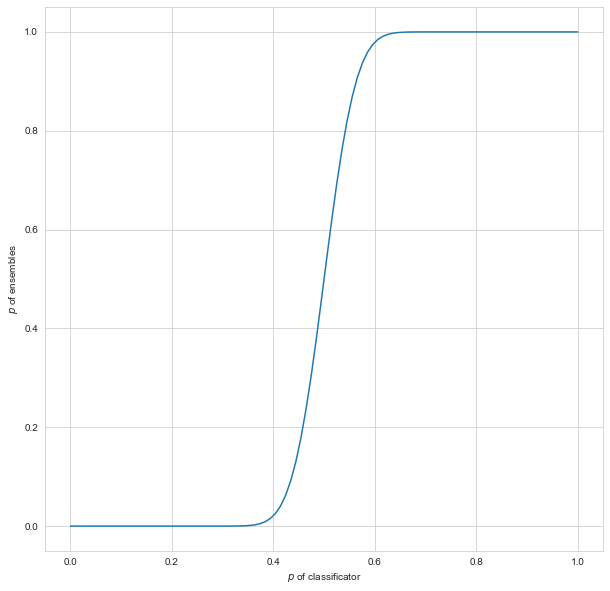

In [11]:
def ensemble_proba_p(p, n=101):
    return ensemble_proba(p, n)

plt.figure(figsize=(10, 10))
x = np.linspace(0.0, 1.0, num=100)
y = np.array(list(map(ensemble_proba_p, x)))
plt.xlabel("$p$ of classificator")
plt.ylabel("$p$ of ensembles")
print(f"ensemble_proba_p(0.6)={ensemble_proba_p(0.6):.3f}")
plt.plot(x, y);

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

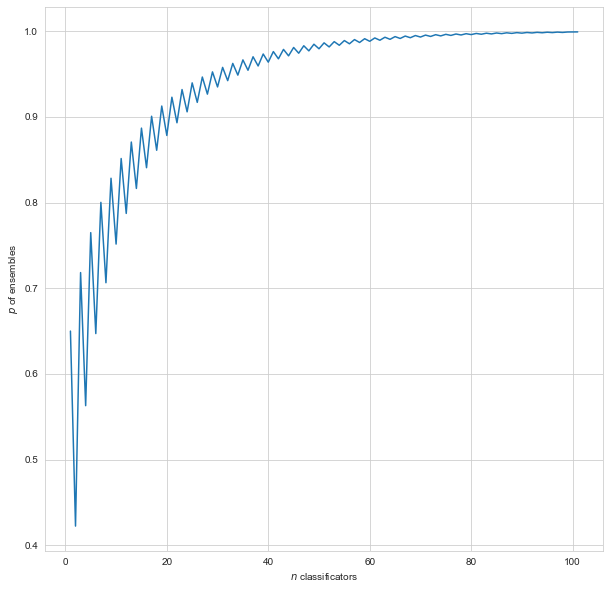

In [13]:
def ensemble_proba_n(n, p=0.65):
    return ensemble_proba(p, n)

plt.figure(figsize=(10, 10))
x = np.linspace(1, 101, num=100, dtype=np.int)
y = np.array(list(map(ensemble_proba_n, x)))
plt.xlabel("$n$ classificators")
plt.ylabel("$p$ of ensembles")
plt.plot(x, y);

Опишите ваши наблюдения:
* <font size=3 color='royalblue'><b>Если мы возьмём классификатор с p=0.6, то ансамбль из сотни таких классификаторов предсказывает класс c вероятностью 0.98. то есть ансамбль слабых классификаторов является хорошей моделью. Или мы можем сказать, что имея классификатор с p=0.6 нам потребуется ансамбль из сотни классификаторов, чтобы получить хорошую модель.</b></font>
* <font size=3 color='royalblue'><b>Нужно взять 40 классификаторов с p=0.65 в ансамбль, чтобы вероятность предсказания ансамбля была 0.97. Зависимость оказалась пилообразной, хотя с увеличением размера ансамбля это поведение становится несущественным.</b></font>

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [14]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids_sample = np.random.choice(np.arange(X.shape[1]), self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids_sample)
            indices_sample = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace=True)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features)
            X_to_fit = X[:, feat_ids_sample][indices_sample]
            if len(feat_ids_sample) == 1:
                X_to_fit = X_to_fit.reshape(-1, 1)

            clf.fit(X_to_fit, y[indices_sample])
            self.trees.append(clf)
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

        proba = np.zeros((X.shape[0], len(self.classes_)))
        for clf, clf_features in zip(self.trees, self.feat_ids_by_tree):
            proba += clf.predict_proba(X[:, clf_features])
        return proba / self.n_estimators
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=10)
    plt.ylabel(r"$x_2$", fontsize=10, rotation=0)

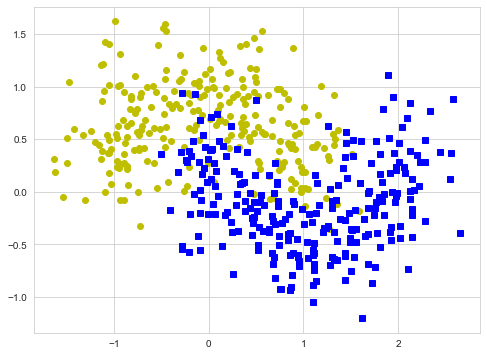

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)
plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show();

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

<font size=3 color='royalblue'><b>Попробуем наш классификатор с разными гиперпараметрами, и будем сравнивать его с библиотечным RandomForestClassifier:</b></font>
- <font size=3 color='royalblue'><b>нарисуем графики с разделяющей границей</b></font>
- <font size=3 color='royalblue'><b>слева будет RandomForestClassifierCustom, справа - RandomForestClassifier</b></font>
- <font size=3 color='royalblue'><b>имя классификатора "Custom10-d10-f1" - RandomForestClassifierCustom, из 10 деревьев, глубиной 10 и одной фичей</b></font>
- <font size=3 color='royalblue'><b>и для каждого посчитаем _MSE_</b></font>

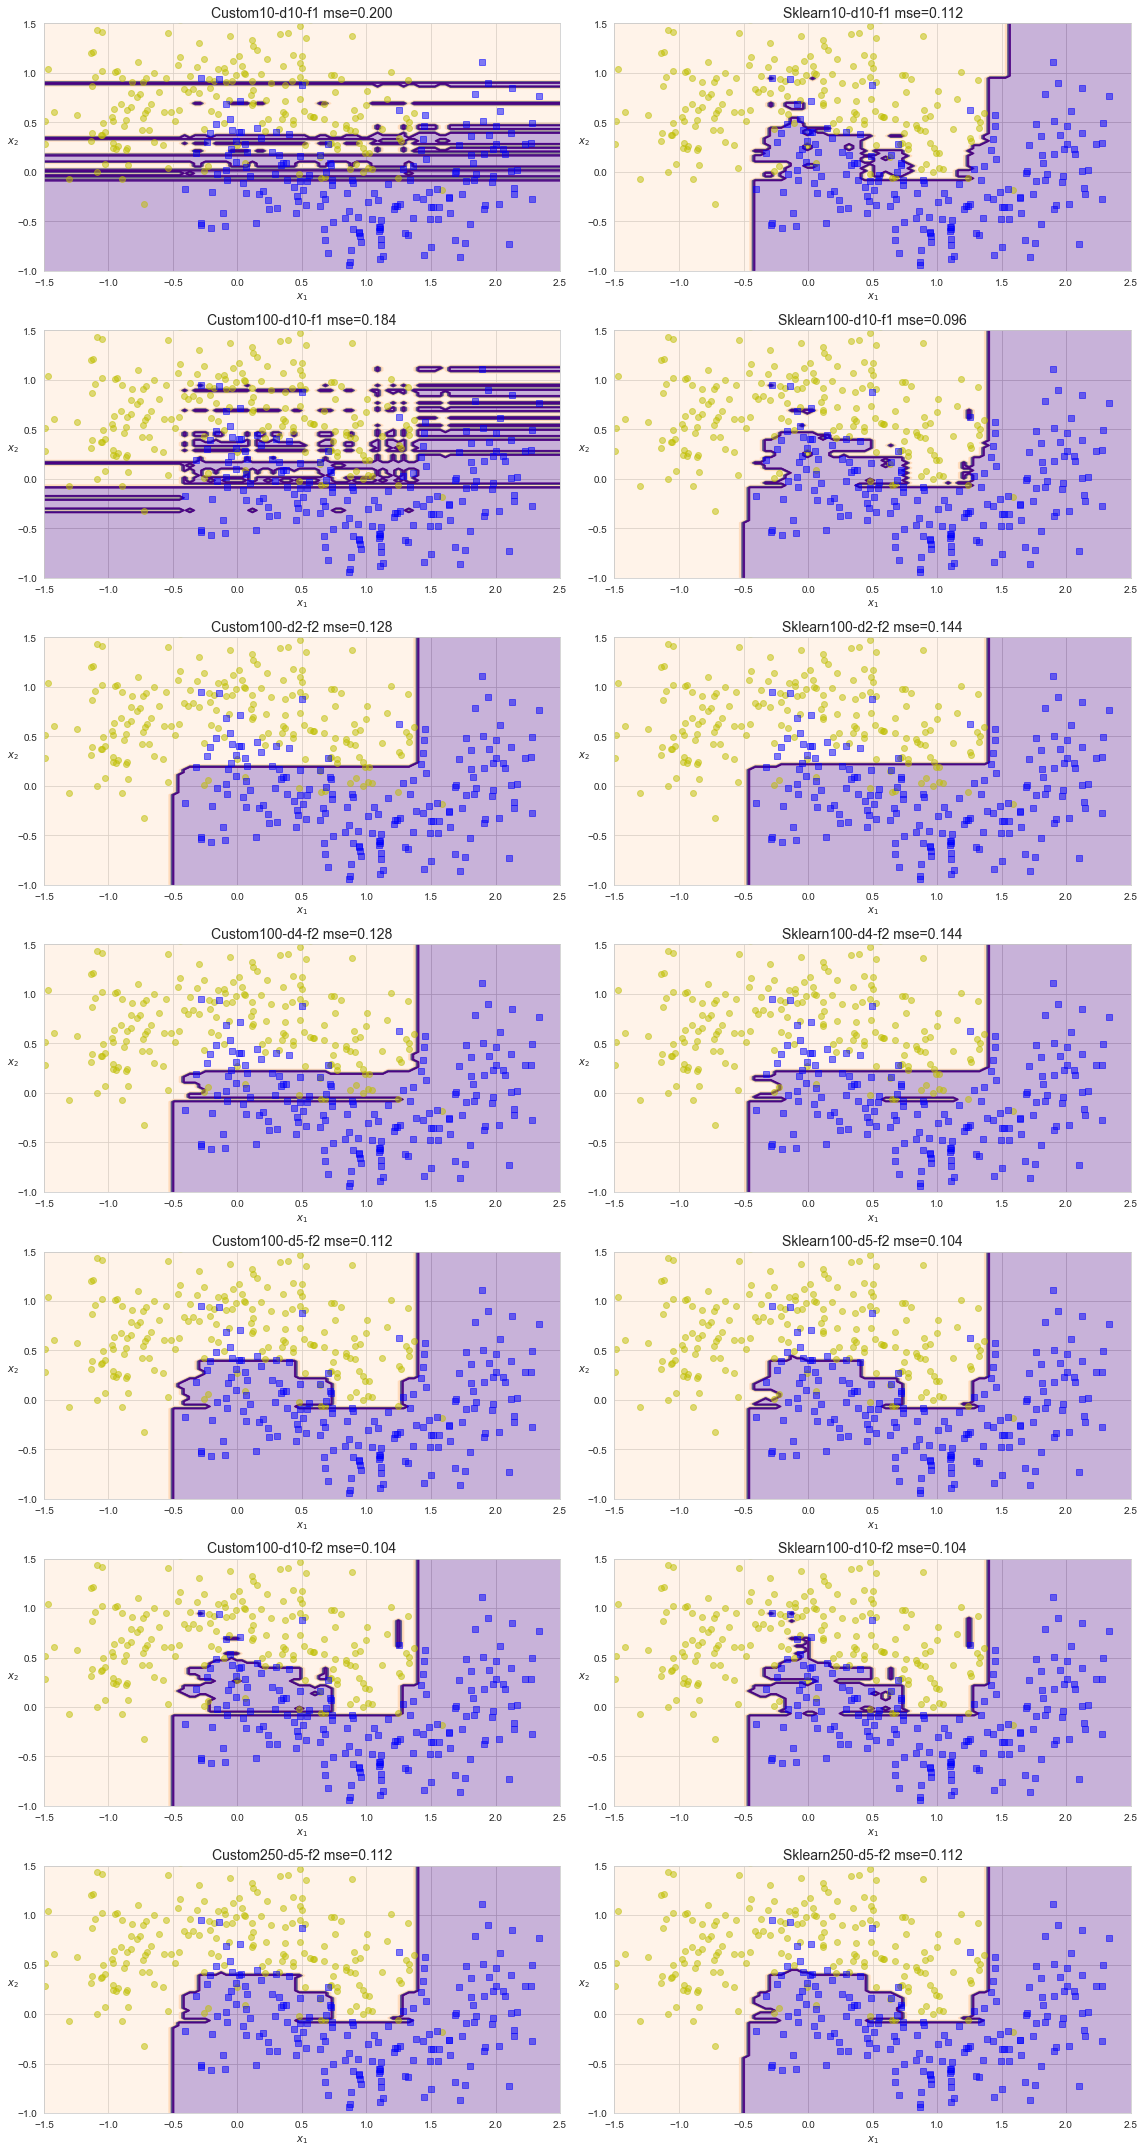

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clfs = {
    "Custom10-d10-f1": RandomForestClassifierCustom(n_estimators=10, max_depth=10, max_features=1, random_state=42),
    "Sklearn10-d10-f1": RandomForestClassifier(n_estimators=10, max_depth=10,  max_features=1, random_state = 42, n_jobs=-1),

    "Custom100-d10-f1": RandomForestClassifierCustom(n_estimators=100, max_depth=10, max_features=1, random_state=42),
    "Sklearn100-d10-f1": RandomForestClassifier(n_estimators=100, max_depth=10,  max_features=1, random_state = 42, n_jobs=-1),

    "Custom100-d2-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=2, max_features=2, random_state=42),
    "Sklearn100-d2-f2": RandomForestClassifier(n_estimators=100, max_depth=2,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom100-d4-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=4, max_features=2, random_state=42),
    "Sklearn100-d4-f2": RandomForestClassifier(n_estimators=100, max_depth=4,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom100-d5-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=5, max_features=2, random_state=42),
    "Sklearn100-d5-f2": RandomForestClassifier(n_estimators=100, max_depth=5,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom100-d10-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=10, max_features=2, random_state=42),
    "Sklearn100-d10-f2": RandomForestClassifier(n_estimators=100, max_depth=10,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom250-d5-f2": RandomForestClassifierCustom(n_estimators=250, max_depth=5, max_features=2, random_state=42),
    "Sklearn250-d5-f2": RandomForestClassifier(n_estimators=250, max_depth=5,  max_features=2, random_state = 42, n_jobs=-1)
}

for name, clf in clfs.items():
    clf.fit(X_train, y_train)

plt.figure(figsize=(16, 30))
for idx, (name, clf) in enumerate(clfs.items()):
    plt.subplot(len(clfs)//2, 2, idx + 1)
    plot_decision_boundary(clf, X_train, y_train)

    mse = mean_squared_error(y_test, clf.predict(X_test))
    plt.title(f"{name} mse={mse:.3f}", fontsize=14)
plt.tight_layout()
plt.subplots_adjust()
plt.show()

<font size=3 color='royalblue'><b>Что мы получили?</b></font>
1. <font size=3 color='royalblue'><b>В целом библиотечный RandomForestClassifier работает лучше нашего
   - <font size=3 color='royalblue'><b>это видно и по MSE (хотя Custom100-d10-f2 работает с такой же ошибкой как и Sklearn100-d10-f2) и визуально по разделяющей границе.</b></font>
2. <font size=3 color='royalblue'><b>Почему-то наш классификатор особенно плох при ```max_features=1```. По сути, он переобучился, нарезав X2 на маленькие отрезки и захватив выбросы синих точек из третьего квадранта. При ```n_estimators=100``` переобучение уже не так велико и _MSE_ уменьшилась с 0.272 до 0.176, но всё же заметно больше, чем у RandomForestClassifier.</b></font>
3. <font size=3 color='royalblue'><b>RandomForestClassifierCustom при глубине 10 предсказывает так же как и при глубине 5 (то же для RandomForestClassifier).</b></font>

<font size=3 color='royalblue'><b>Затем я попробовала еще два случая:</b></font>
- <font size=3 color='royalblue'><b>Глубину 4: Custom100-d4-f2 и Sklearn100-d4-f2, она оказалась чуть хуже depth=5</b></font>
- <font size=3 color='royalblue'><b>Custom250-d5-f2 + Sklearn250-d5-f2: почему-то библиотечный лес выдал _MSE=0.112_, при том что для 100 деревьев он давал _MSE=0.104_, то есть меньшую ошибку. Хотелось бы понять почему?</b></font>

4. <font size=3 color='royalblue'><b>Тем не менее мы знаем, что depth=5 дает минимальную ошибку MSE.</b></font>

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [19]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

<font size=3 color='royalblue'><b>Предыдущий пункт уже частично отвечает на вопрос: мы знаем оптимальные глубину (5) и max_features (2).
В том числе, кажется что n_estimators=100 дает хорошие результаты.</b></font>

<font size=3 color='royalblue'><b>Мы уже знаем, что глубина 5 - это оптимальная глубина с точки зрения минимизации ошибки.
Сравним обычное дерево глубиной 10 и наш лес глубиной 10.
Мы ожидаем, что DT переобучит модель, а RF породит хорошую модель, с меньшим variance:</b></font>

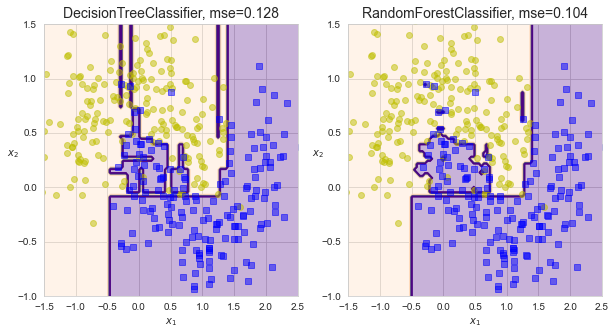

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=10, random_state=42)
clf1.fit(X_train, y_train)
mse1 = mean_squared_error(y_test, clf1.predict(X_test))

clf2 = RandomForestClassifierCustom(n_estimators=100, max_depth=10,  max_features=2, random_state = 42)
clf2.fit(X_train, y_train)
mse2 = mean_squared_error(y_test, clf2.predict(X_test))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_decision_boundary(clf1, X_train, y_train)
plt.title(f"DecisionTreeClassifier, mse={mse1:.3f}", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X_train, y_train)
plt.title(f"RandomForestClassifier, mse={mse2:.3f}", fontsize=14)
plt.show()

<font size=3 color='royalblue'><b>Так и вышло: RF не переобучается.</b></font>

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [21]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [22]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [24]:
print(f"X has {X.shape[1]} features")

X has 30 features


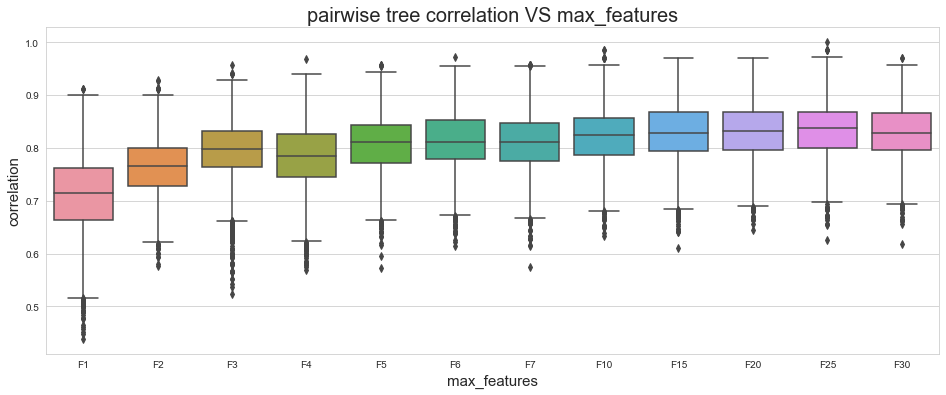

In [25]:
plt.figure(figsize=(16,6))
x_plot = []
y_plot = []

for max_features in [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30]:
    clf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state = 42)
    clf.fit(X_train, y_train)
    corr = base_model_pair_correlation(clf, X_test)
    y_plot.append(corr)
    x_plot += [f"F{max_features}"]*len(corr)

sns.boxplot(y=np.concatenate(y_plot), x=x_plot)

plt.ylabel("correlation", size=15)
plt.xlabel("max_features", size=15)
plt.title("pairwise tree correlation VS max_features", size=20)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [26]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

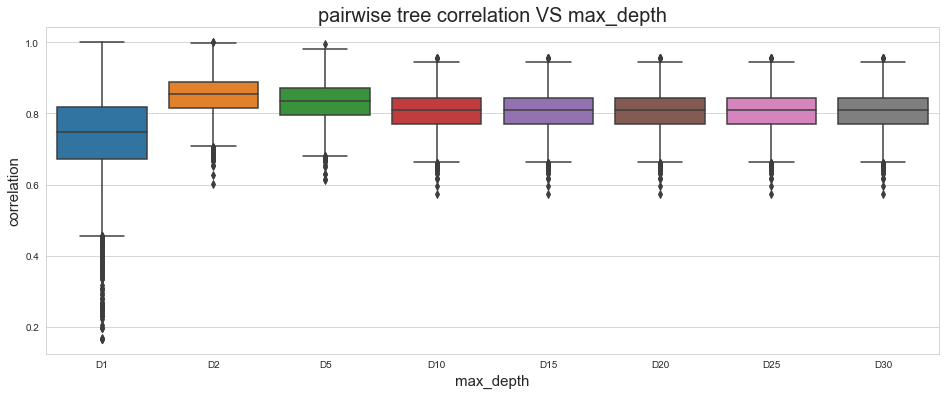

In [27]:
plt.figure(figsize=(16,6))
x_plot = []
y_plot = []

for max_depth in [1, 2, 5, 10, 15, 20, 25, 30]:
    clf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state = 42)
    clf.fit(X_train, y_train)
    corr = base_model_pair_correlation(clf, X_test)
    y_plot.append(corr)
    x_plot += [f"D{max_depth}"]*len(corr)

sns.boxplot(y=np.concatenate(y_plot), x=x_plot)

plt.ylabel("correlation", size=15)
plt.xlabel("max_depth", size=15)
plt.title("pairwise tree correlation VS max_depth", size=20)
plt.show()

Опишите ваши наблюдения:

* <font size=3 color='royalblue'><b>Корреляция в целом растет с ростом _max_feature_, при этом она уже больше 0.7.</b></font> 

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [28]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [29]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


In [30]:
SC = StandardScaler()
X_std = SC.fit_transform(X)
SC2 = StandardScaler()
X_train = SC2.fit_transform(X_train)
X_test = SC2.transform(X_test)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [31]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=False, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgboost.set_config(verbosity=0)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [32]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(voting="hard", estimators=base_models)
voting_soft = VotingClassifier(voting="soft", estimators=base_models)

In [33]:
## END YOUR CODE HERE ##
output = []
for name, model in base_models + [("VotingHard", voting_hard), ("VotingSoft", voting_soft)]:
    scores = cross_val_score(model, X_std, y, cv=3, scoring="f1")
    # msg = (f"{model.__class__.__name__}", scores.mean())
    msg = (scores.mean(), name, model.__class__.__name__)
    output.append(msg)

output.sort(key=lambda m: m[0], reverse=True)
for msg in output:
    print(f"{msg[0]:.3f} {msg[1]:>10} {msg[2]}")

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.854         LR LogisticRegression
0.852 VotingSoft VotingClassifier
0.851    SVC_LIN SVC
0.847        CAT CatBoostClassifier
0.843 VotingHard VotingClassifier
0.843         RF RandomForestClassifier
0.843    SVC_RBF SVC
0.841    LGBM_RF LGBMClassifier
0.834       LGBM LGBMClassifier
0.833        ETC ExtraTreesClassifier
0

<font size=3 color='royalblue'><b>Ансамбли дают предсказания с качеством 0.843 (hard) и 0.852 (soft), при этом LogisticRegression работает с 0.854.
Кажется, что voting=soft должен дать нам лучшие результаты, нежели voting=hard.</b></font>

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [34]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.named_estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(ensemble.named_estimators_[est1], SVC):
            ypred_t1 = ensemble.named_estimators_[est1].predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = ensemble.named_estimators_[est1].decision_function(Xi_test)


        if not isinstance(ensemble.named_estimators_[est2], SVC):
            ypred_t2 = ensemble.named_estimators_[est2].predict_proba(Xj_test)[:, 1]
        else:
            ypred_t2 = ensemble.named_estimators_[est2].decision_function(Xj_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [35]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [36]:
# voting_hard = VotingClassifier(voting="hard", estimators=base_models)
voting_soft = VotingClassifier(voting="soft", estimators=base_models)

voting_soft.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

for i in corrs :
    print(i[0] + ' ' + i[1] + ' ' + str(i[2]))


DT RF 0.8075082819576244
DT ETC 0.7749544834941163
DT KNN 0.6497945491547565
DT SVC_LIN 0.7185467241903389
DT SVC_RBF 0.7316131164643038
DT CAT 0.7872535788811532
DT LGBM 0.8278855729048328
DT LGBM_RF 0.8598637726182208
DT XGB 0.8049350936978588
DT XGB_RF 0.8865011197877022
DT LR 0.7459475165365808
DT NB 0.6827705830503709
RF ETC 0.9217050880600524
RF KNN 0.8301323542205487
RF SVC_LIN 0.8212332826196334
RF SVC_RBF 0.9026282409939271
RF CAT 0.9475472159450767
RF LGBM 0.9209372007772746
RF LGBM_RF 0.9109852617658276
RF XGB 0.9051732684156619
RF XGB_RF 0.9323112763562647
RF LR 0.8540919169607701
RF NB 0.7967089775552949
ETC KNN 0.9030497139868621
ETC SVC_LIN 0.8884821480509469
ETC SVC_RBF 0.9392222123118492
ETC CAT 0.9525772887050153
ETC LGBM 0.9012287706993566
ETC LGBM_RF 0.8563729899675916
ETC XGB 0.8688135032387717
ETC XGB_RF 0.8922124263651331
ETC LR 0.889441556546851
ETC NB 0.8522993742175913
KNN SVC_LIN 0.8144884911178473
KNN SVC_RBF 0.8983066898377788
KNN CAT 0.8443401879453708
KNN

<font size=3 color='royalblue'><b>Анализировать список корреляций трудно, попробуем построить heatmap корреляций, это нагляднее:</b></font>

In [37]:
def plot_heatmap_corr(corrs):
    data_for_df = {"e1": [], "e2": [], "corr": []}
    for e1, e2, corr in corrs:
        data_for_df["e1"].append(e1)
        data_for_df["e2"].append(e2)
        data_for_df["corr"].append(corr)

    df = pd.DataFrame(data_for_df)
    df_pt = pd.pivot_table(df, values=['corr'], index=['e1'], columns=['e2'])
    # print(df_pt)
    sns.heatmap(data=df_pt, annot=True, center=1)

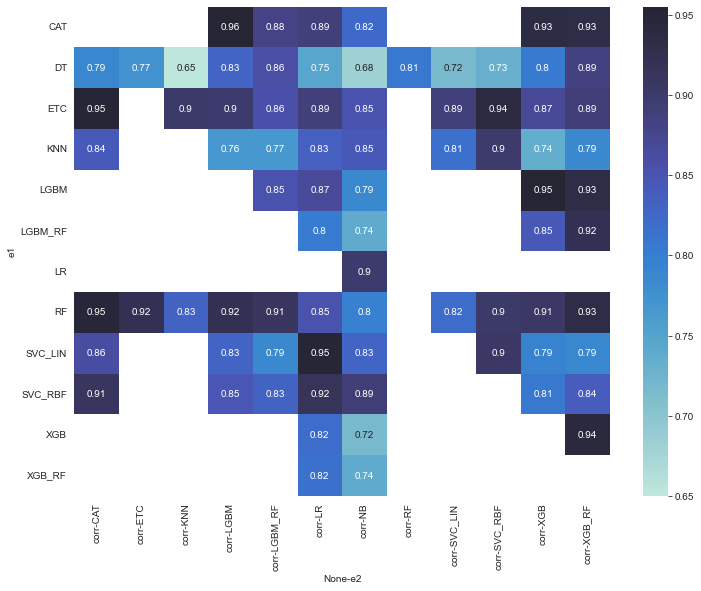

In [38]:
plot_heatmap_corr(corrs)

<font size=3 color='royalblue'><b>Что мы видим?</b></font>
1. <font size=3 color='royalblue'><b>DecisionTreeClassifier и GaussianNB имеют более низкую корреляцию со всем остальными классификаторами</b></font>

2. <font size=3 color='royalblue'><b>В целом, пробовать удалять классификатор вручную и анализировать f1-score -- довольно трудоёмко и кажется что проще просто перебрать все варианты.</b></font>

<font size=3 color='royalblue'><b>Сделаем перебор: всех пар классификаторов и всех троек классификаторов.</b></font>

In [39]:
# перебор пар

base_est = [("DT", dt), ("RF", rf), ("ETC", etc), ("KNN", knn),  ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
 ("CAT", cat), ("LGBM", lgbm),  ("LGBM_RF", lgbm_rf), ("XGB", xgb),  ("XGB_RF", xgb_rf),
 ("LR", lr), ("NB", nb)]

results = []
for est1, est2 in combinations(base_est, 2):
    voting_hard = VotingClassifier(voting="soft", estimators=[est1, est2])
    # voting_hard.fit(X_train, y_train)
    score = cross_val_score(voting_hard, X_std, y, cv=3, scoring="f1").mean()
    results.append((score, est1[0], est2[0]))
results.sort(key=lambda i: i[0], reverse=True)

for s, e1, e2 in results:
    print(f"{s:.3f} {e1} {e2}")

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

In [40]:
# перебор троек

base_est = [("DT", dt), ("RF", rf), ("ETC", etc), ("KNN", knn),  ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
 ("CAT", cat), ("LGBM", lgbm),  ("LGBM_RF", lgbm_rf), ("XGB", xgb),  ("XGB_RF", xgb_rf),
 ("LR", lr), ("NB", nb)]

results = []
for est1, est2, est3 in combinations(base_est, 3):
    voting_hard = VotingClassifier(voting="soft", estimators=[est1, est2, est3])
#     voting_hard.fit(X_train, y_train)
    score = cross_val_score(voting_hard, X_std, y, cv=3, scoring="f1").mean()
    results.append((score, est1[0], est2[0], est3[0]))
results.sort(key=lambda i: i[0], reverse=True)

for s, e1, e2, e3 in results:
    print(f"{s:.3f} {e1} {e2} {e3}")

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

**Топ 3 для троек:**<br>
0.865 SVC_LIN LGBM_RF LR<br>
0.865 SVC_LIN XGB_RF LR<br>
0.865 SVC_LIN XGB NB<br>

**Топ 3 для пар:**<br>
0.859 RF LR<br>
0.859 LGBM_RF LR<br>
0.859 SVC_LIN LGBM_RF<br>
0.858 LGBM NB<br>

<font size=4 color='royalblue'><b>Лучший скор удалось получить для ансамблей из троек высоко-скорелированных моделей.</b></font>

------------------------------------------

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [41]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

### <font size=5 color='royalblue'><b>EDA</b></font>

In [42]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


<font size=3 color='royalblue'><b>Переименуем колонки 'Churn?' и 'Int'l Plan' чтобы избежать возможных проблем.</b></font>

In [43]:
data=data.rename(columns={'Churn?':'churn'})
data=data.rename(columns={"Int'l Plan":"Intl Plan"})
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Intl Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'churn'],
      dtype='object')

<font size=3 color='royalblue'><b>Почистим данные и уберем неинформативные колонки.
А также конвертируем категориальные параметры в количественные.</b></font>

In [44]:
data = data.drop(columns=['State', 'Area Code', 'Phone'], axis = 1)
data = pd.get_dummies(data=data, columns=["Intl Plan", 'VMail Plan'])
data = data.drop(columns=['Intl Plan_no', 'VMail Plan_no'])
data['churn'] = data['churn'].apply(lambda x:1 if x=="True." else 0 )
data.head()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,churn,Intl Plan_yes,VMail Plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,1,0


<font size=3 color='royalblue'><b>Проверим, что значения в "у" измененились корректно.</b></font>

In [45]:
data['churn'].unique()

array([0, 1], dtype=int64)

<font size=3 color='royalblue'><b>Дальше подготовим данные для анализа.</b></font>

In [46]:
X = data.drop(columns = ['churn'])
y = data['churn']

In [47]:
SEED = 666

<AxesSubplot:xlabel='churn', ylabel='Count'>

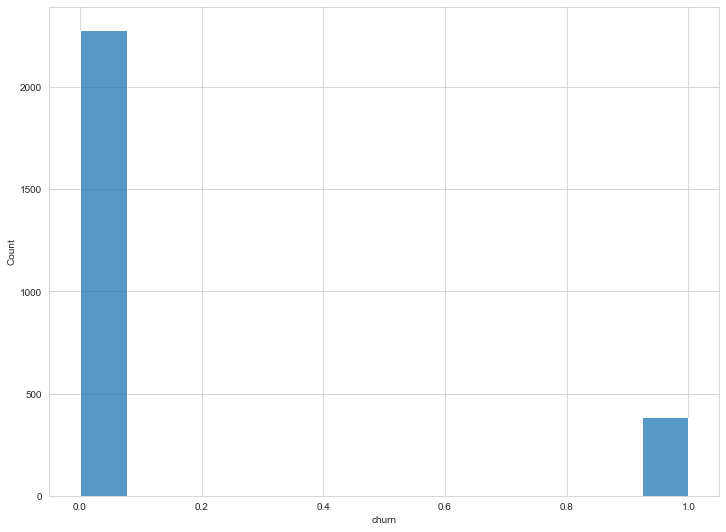

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
sns.histplot(y_train)

<font size=3 color='royalblue'><b>Поскольку в данных присутсвует сильный дисбаланс классов, применим параметры в наших 2х моделях для сглаживания дисбаланс.</b></font>

In [49]:
SC = StandardScaler()
X_train = SC.fit_transform(X_train)
X_test = SC.transform(X_test)
print(X_train)

[[ 2.70081204 -0.58148342  1.3539314  ...  1.09897294 -0.32380355
  -0.60653192]
 [-1.57498363  2.07530286 -1.18727005 ...  0.33399595 -0.32380355
   1.64871786]
 [-0.57479751 -0.58148342  1.02104674 ... -0.43098103  3.08829231
  -0.60653192]
 ...
 [-0.62480682 -0.58148342 -0.02672136 ... -1.19595802 -0.32380355
  -0.60653192]
 [ 1.20053286  0.89450896  0.33162989 ... -0.43098103 -0.32380355
   1.64871786]
 [-0.69982078 -0.58148342  0.12062103 ... -0.43098103 -0.32380355
  -0.60653192]]


### xgboost.XGBRFClassifier

<font size=3 color='royalblue'><b>Будем использовать GridSearch с параметром **Recall**, так как мы хотим идентифицировать всех потенциально потерянных клиентов.</b></font>

In [50]:
# Initial parameters
XGBRF = xgboost.XGBRFClassifier()
params = {'eta': [0.05, 0.1, 0.2], 
          'min_child_weight' : [0.5, 1, 1.5], 
          'max_depth': [3, 6, 10], 
          'max_leaf_nodes' : [10, 30], 
          'gamma' : [0.0, 0.2 , 0.4],
          'subsample' : [0.5, 1],
          'colsample_bytree' : [0.3, 0.66, 1], 
          'seed' : [SEED]}
cv_tree = GridSearchCV(XGBRF, params, scoring = 'recall')
cv_tree.fit(X_train, y_train)
cv_tree.best_params_

**Initial parameters results** <br>
{'colsample_bytree': 1,<br>
 'eta': 0.05,<br>
 'gamma': 0.0,<br>
 'max_depth': 10,<br>
 'max_leaf_nodes': 10,<br>
 'min_child_weight': 0.5,<br>
 'seed': 666,<br>
 'subsample': 0.5}

In [51]:
y_pred = cv_tree.best_estimator_.predict(X_test)
print(recall_score(y_test, y_pred, average = 'binary'))

**Updated recall_score** = 0.6804123711340206

<font size=3 color='royalblue'><b>Неплохой результат - но видно, что лучшие параметры являются крайними значениями из предложенных диапазонов. Можно попробовать поиграть с ними, подкручивая в направлении, которое раньше не учитывалось.
'colsample_bytree' принимает значение [1] как лучшее, но это означает, что для каждого дерева он берет полный набор фич, что противоречит идеи Random Forest. Попробуем зажать его в рамках [0.3, 0.6].</b></font>

In [52]:
# Updated parameters
XGBRF = xgboost.XGBRFClassifier()
params = {'eta': [0.025, 0.05, 0.1], 
          'min_child_weight' : [0.25, 0.5, 1], 
          'max_depth': [10, 20], 
          'max_leaf_nodes' : [1, 10], 
          'subsample' : [0.25, 0.5],
          'colsample_bytree' : [0.3, 0.6, 1], 
          'seed' : [SEED]}
cv_tree = GridSearchCV(XGBRF, params, scoring = 'recall')
cv_tree.fit(X_train, y_train)
cv_tree.best_params_

**Updated parameters results** <br>
{'colsample_bytree': 0.6, <br>
 'eta': 0.025, <br>
 'max_depth': 20, <br>
 'max_leaf_nodes': 1, <br>
 'min_child_weight': 0.25, <br>
 'seed': 666, <br>
 'subsample': 0.5}

In [53]:
y_pred = cv_tree.best_estimator_.predict(X_test)
print(recall_score(y_test, y_pred, average = 'binary'))

**Updated recall_score** = 0.5876288659793815

<font size=3 color='royalblue'><b>Жёсткое ограничение 'colsample_bytree' параметра привело к **снижению recall_score. Попробуем вернуть прежнее значение [1].**</b></font>

In [54]:
# Updated parameters2
XGBRF = xgboost.XGBRFClassifier()
params = {'eta': [0.025, 0.05, 0.1], 
          'min_child_weight' : [0.25, 0.5, 1], 
          'max_depth': [10, 20], 
          'max_leaf_nodes' : [1, 10], 
          'subsample' : [0.25, 0.5],
          'colsample_bytree' : [1], 
          'seed' : [SEED]}
cv_tree = GridSearchCV(XGBRF, params, scoring = 'recall')
cv_tree.fit(X_train, y_train)
cv_tree.best_params_

**Updated parameters2 results** <br>
{'colsample_bytree': 1,<br>
 'eta': 0.025,<br>
 'max_depth': 10,<br>
 'max_leaf_nodes': 1,<br>
 'min_child_weight': 0.25,<br>
 'seed': 666,<br>
 'subsample': 0.5}<br>

In [55]:
y_pred = cv_tree.best_estimator_.predict(X_test)
print(recall_score(y_test, y_pred, average = 'binary'))

**Updated2 recall_score** = 0.6804123711340206

<font size=4 color='royalblue'><b>Вывод: Поскольку результат изменился незначительно, можно считать, что мы достигли оптимальных параметров.</b></font>

![](https://miro.medium.com/max/1240/1*Zmv9NPx9nq88Plbuy6eKaQ.jpeg)

### catboost.CatBoostClassifier

In [56]:
Cat = catboost.CatBoostClassifier()
params = {'eval_metric' : ['Recall'],
          'od_pval' : [0.0000000001, 0.01],
          'boosting_type' : ['Ordered','Plain'],
          'depth' : [4, 7, 10],
          'l2_leaf_reg' : [2, 3, 4],
          'grow_policy' : ['SymmetricTree','Depthwise','Lossguide'], 
          'random_state' : [SEED]}
cb_tree = GridSearchCV(Cat, params, scoring = 'recall')
# cb_tree.fit(X_train, y_train)
# cb_tree.best_params_

In [57]:
cb_tree.fit(X_train, y_train)
cb_tree.best_params_

**Results of the GridSearch for the CatBoostClassifier, attempt1:**
    
{'boosting_type': 'Ordered', <br>
 'depth': 7, <br>
 'eval_metric': 'Recall',<br>
 'grow_policy': 'SymmetricTree',<br>
 'l2_leaf_reg': 2,<br>
 'od_pval': 1e-10,<br>
 'random_state': 666}

In [58]:
# With best parameters
Cat = catboost.CatBoostClassifier(boosting_type = 'Ordered', 
                                  depth = 7, 
                                  eval_metric = 'Recall', 
                                  grow_policy = 'SymmetricTree', 
                                  l2_leaf_reg = 2, 
                                  od_pval = 1e-10, 
                                  random_state = SEED)

In [59]:
Cat.fit(X_train, y_train)

0:	learn: 0.3575130	total: 36.2ms	remaining: 36.2s
1:	learn: 0.1450777	total: 53.6ms	remaining: 26.8s
2:	learn: 0.2357513	total: 72.3ms	remaining: 24s
3:	learn: 0.2823834	total: 89.6ms	remaining: 22.3s
4:	learn: 0.3031088	total: 106ms	remaining: 21.1s
5:	learn: 0.3238342	total: 123ms	remaining: 20.4s
6:	learn: 0.4093264	total: 141ms	remaining: 20s
7:	learn: 0.4715026	total: 159ms	remaining: 19.7s
8:	learn: 0.4870466	total: 177ms	remaining: 19.5s
9:	learn: 0.4870466	total: 194ms	remaining: 19.2s
10:	learn: 0.4844560	total: 214ms	remaining: 19.2s
11:	learn: 0.5025907	total: 233ms	remaining: 19.2s
12:	learn: 0.4870466	total: 237ms	remaining: 18s
13:	learn: 0.5000000	total: 258ms	remaining: 18.2s
14:	learn: 0.5233161	total: 279ms	remaining: 18.4s
15:	learn: 0.4896373	total: 297ms	remaining: 18.3s
16:	learn: 0.5025907	total: 318ms	remaining: 18.4s
17:	learn: 0.5077720	total: 339ms	remaining: 18.5s
18:	learn: 0.5777202	total: 358ms	remaining: 18.5s
19:	learn: 0.5440415	total: 378ms	remaining

168:	learn: 0.8290155	total: 3.34s	remaining: 16.4s
169:	learn: 0.8316062	total: 3.36s	remaining: 16.4s
170:	learn: 0.8316062	total: 3.38s	remaining: 16.4s
171:	learn: 0.8341969	total: 3.4s	remaining: 16.4s
172:	learn: 0.8367876	total: 3.42s	remaining: 16.3s
173:	learn: 0.8393782	total: 3.44s	remaining: 16.3s
174:	learn: 0.8393782	total: 3.46s	remaining: 16.3s
175:	learn: 0.8393782	total: 3.47s	remaining: 16.3s
176:	learn: 0.8367876	total: 3.49s	remaining: 16.2s
177:	learn: 0.8367876	total: 3.51s	remaining: 16.2s
178:	learn: 0.8367876	total: 3.53s	remaining: 16.2s
179:	learn: 0.8393782	total: 3.55s	remaining: 16.2s
180:	learn: 0.8393782	total: 3.57s	remaining: 16.1s
181:	learn: 0.8419689	total: 3.59s	remaining: 16.1s
182:	learn: 0.8419689	total: 3.6s	remaining: 16.1s
183:	learn: 0.8419689	total: 3.62s	remaining: 16.1s
184:	learn: 0.8419689	total: 3.64s	remaining: 16s
185:	learn: 0.8419689	total: 3.66s	remaining: 16s
186:	learn: 0.8419689	total: 3.67s	remaining: 16s
187:	learn: 0.844559

327:	learn: 0.8652850	total: 6.23s	remaining: 12.8s
328:	learn: 0.8652850	total: 6.25s	remaining: 12.7s
329:	learn: 0.8652850	total: 6.27s	remaining: 12.7s
330:	learn: 0.8652850	total: 6.29s	remaining: 12.7s
331:	learn: 0.8652850	total: 6.31s	remaining: 12.7s
332:	learn: 0.8652850	total: 6.33s	remaining: 12.7s
333:	learn: 0.8652850	total: 6.34s	remaining: 12.7s
334:	learn: 0.8652850	total: 6.36s	remaining: 12.6s
335:	learn: 0.8652850	total: 6.38s	remaining: 12.6s
336:	learn: 0.8652850	total: 6.4s	remaining: 12.6s
337:	learn: 0.8652850	total: 6.41s	remaining: 12.6s
338:	learn: 0.8652850	total: 6.43s	remaining: 12.5s
339:	learn: 0.8652850	total: 6.45s	remaining: 12.5s
340:	learn: 0.8652850	total: 6.47s	remaining: 12.5s
341:	learn: 0.8652850	total: 6.49s	remaining: 12.5s
342:	learn: 0.8652850	total: 6.5s	remaining: 12.5s
343:	learn: 0.8652850	total: 6.52s	remaining: 12.4s
344:	learn: 0.8652850	total: 6.54s	remaining: 12.4s
345:	learn: 0.8652850	total: 6.56s	remaining: 12.4s
346:	learn: 0.

487:	learn: 0.8704663	total: 9.32s	remaining: 9.77s
488:	learn: 0.8730570	total: 9.34s	remaining: 9.76s
489:	learn: 0.8730570	total: 9.36s	remaining: 9.74s
490:	learn: 0.8730570	total: 9.38s	remaining: 9.73s
491:	learn: 0.8730570	total: 9.4s	remaining: 9.71s
492:	learn: 0.8730570	total: 9.43s	remaining: 9.7s
493:	learn: 0.8730570	total: 9.45s	remaining: 9.68s
494:	learn: 0.8730570	total: 9.47s	remaining: 9.66s
495:	learn: 0.8730570	total: 9.48s	remaining: 9.64s
496:	learn: 0.8730570	total: 9.51s	remaining: 9.63s
497:	learn: 0.8730570	total: 9.53s	remaining: 9.61s
498:	learn: 0.8730570	total: 9.55s	remaining: 9.59s
499:	learn: 0.8756477	total: 9.57s	remaining: 9.57s
500:	learn: 0.8756477	total: 9.59s	remaining: 9.55s
501:	learn: 0.8756477	total: 9.61s	remaining: 9.53s
502:	learn: 0.8782383	total: 9.63s	remaining: 9.52s
503:	learn: 0.8808290	total: 9.65s	remaining: 9.5s
504:	learn: 0.8808290	total: 9.67s	remaining: 9.48s
505:	learn: 0.8808290	total: 9.69s	remaining: 9.46s
506:	learn: 0.8

646:	learn: 0.8886010	total: 12.4s	remaining: 6.79s
647:	learn: 0.8886010	total: 12.5s	remaining: 6.77s
648:	learn: 0.8886010	total: 12.5s	remaining: 6.75s
649:	learn: 0.8886010	total: 12.5s	remaining: 6.74s
650:	learn: 0.8886010	total: 12.5s	remaining: 6.72s
651:	learn: 0.8886010	total: 12.5s	remaining: 6.7s
652:	learn: 0.8886010	total: 12.6s	remaining: 6.68s
653:	learn: 0.8886010	total: 12.6s	remaining: 6.66s
654:	learn: 0.8886010	total: 12.6s	remaining: 6.64s
655:	learn: 0.8886010	total: 12.6s	remaining: 6.62s
656:	learn: 0.8886010	total: 12.6s	remaining: 6.6s
657:	learn: 0.8886010	total: 12.7s	remaining: 6.58s
658:	learn: 0.8886010	total: 12.7s	remaining: 6.56s
659:	learn: 0.8886010	total: 12.7s	remaining: 6.54s
660:	learn: 0.8886010	total: 12.7s	remaining: 6.53s
661:	learn: 0.8886010	total: 12.7s	remaining: 6.51s
662:	learn: 0.8886010	total: 12.8s	remaining: 6.49s
663:	learn: 0.8886010	total: 12.8s	remaining: 6.47s
664:	learn: 0.8886010	total: 12.8s	remaining: 6.45s
665:	learn: 0.

809:	learn: 0.8989637	total: 15.8s	remaining: 3.71s
810:	learn: 0.8989637	total: 15.8s	remaining: 3.69s
811:	learn: 0.8989637	total: 15.8s	remaining: 3.67s
812:	learn: 0.8989637	total: 15.9s	remaining: 3.65s
813:	learn: 0.8989637	total: 15.9s	remaining: 3.63s
814:	learn: 0.8989637	total: 15.9s	remaining: 3.61s
815:	learn: 0.8989637	total: 15.9s	remaining: 3.59s
816:	learn: 0.8989637	total: 15.9s	remaining: 3.57s
817:	learn: 0.8989637	total: 16s	remaining: 3.55s
818:	learn: 0.8989637	total: 16s	remaining: 3.53s
819:	learn: 0.8989637	total: 16s	remaining: 3.51s
820:	learn: 0.8989637	total: 16s	remaining: 3.5s
821:	learn: 0.8989637	total: 16.1s	remaining: 3.48s
822:	learn: 0.8989637	total: 16.1s	remaining: 3.46s
823:	learn: 0.8989637	total: 16.1s	remaining: 3.44s
824:	learn: 0.8989637	total: 16.1s	remaining: 3.42s
825:	learn: 0.8989637	total: 16.1s	remaining: 3.4s
826:	learn: 0.8989637	total: 16.2s	remaining: 3.38s
827:	learn: 0.8989637	total: 16.2s	remaining: 3.36s
828:	learn: 0.8989637	

974:	learn: 0.9067358	total: 19.2s	remaining: 491ms
975:	learn: 0.9067358	total: 19.2s	remaining: 472ms
976:	learn: 0.9067358	total: 19.2s	remaining: 452ms
977:	learn: 0.9067358	total: 19.2s	remaining: 432ms
978:	learn: 0.9067358	total: 19.2s	remaining: 413ms
979:	learn: 0.9067358	total: 19.3s	remaining: 393ms
980:	learn: 0.9067358	total: 19.3s	remaining: 373ms
981:	learn: 0.9067358	total: 19.3s	remaining: 354ms
982:	learn: 0.9067358	total: 19.3s	remaining: 334ms
983:	learn: 0.9067358	total: 19.4s	remaining: 315ms
984:	learn: 0.9067358	total: 19.4s	remaining: 295ms
985:	learn: 0.9067358	total: 19.4s	remaining: 275ms
986:	learn: 0.9067358	total: 19.4s	remaining: 256ms
987:	learn: 0.9067358	total: 19.4s	remaining: 236ms
988:	learn: 0.9067358	total: 19.5s	remaining: 216ms
989:	learn: 0.9067358	total: 19.5s	remaining: 197ms
990:	learn: 0.9067358	total: 19.5s	remaining: 177ms
991:	learn: 0.9067358	total: 19.5s	remaining: 157ms
992:	learn: 0.9067358	total: 19.5s	remaining: 138ms
993:	learn: 

In [60]:
y_pred = Cat.predict(X_test)
print(recall_score(y_test, y_pred, average = 'binary'))

0.7319587628865979


<font size=4 color='royalblue'><b>Вывод: Получили recall_score = 0,7319587628865979 с CatBoostClassifier - он выше, чем получилось с лучшими параметрами для XGBRFClassifier. Неплохо!  (=^・・^=) </b></font>

### **Let's try an ensemble of CatBoostClassifier and XGBRFClassifier:**

In [61]:
XGBRF = xgboost.XGBRFClassifier(colsample_bytree = 1,
                                eta = 0.025,
                                max_depth = 10,
                                max_leaf_nodes = 1,
                                min_child_weight = 0.25,
                                seed = SEED,
                                subsample = 0.5)

In [62]:
ensemble = [('XGBRF', XGBRF), ('CAT', Cat)]
voting_soft = VotingClassifier(voting="soft", estimators=ensemble)
voting_soft.fit(X_train, y_train)

0:	learn: 0.3575130	total: 20.7ms	remaining: 20.6s
1:	learn: 0.1450777	total: 38.6ms	remaining: 19.2s
2:	learn: 0.2357513	total: 57.5ms	remaining: 19.1s
3:	learn: 0.2823834	total: 78ms	remaining: 19.4s
4:	learn: 0.3031088	total: 97.8ms	remaining: 19.5s
5:	learn: 0.3238342	total: 117ms	remaining: 19.4s
6:	learn: 0.4093264	total: 138ms	remaining: 19.5s
7:	learn: 0.4715026	total: 159ms	remaining: 19.7s
8:	learn: 0.4870466	total: 177ms	remaining: 19.5s
9:	learn: 0.4870466	total: 197ms	remaining: 19.5s
10:	learn: 0.4844560	total: 219ms	remaining: 19.7s
11:	learn: 0.5025907	total: 241ms	remaining: 19.8s
12:	learn: 0.4870466	total: 246ms	remaining: 18.7s
13:	learn: 0.5000000	total: 266ms	remaining: 18.7s
14:	learn: 0.5233161	total: 286ms	remaining: 18.8s
15:	learn: 0.4896373	total: 305ms	remaining: 18.8s
16:	learn: 0.5025907	total: 324ms	remaining: 18.8s
17:	learn: 0.5077720	total: 345ms	remaining: 18.8s
18:	learn: 0.5777202	total: 365ms	remaining: 18.9s
19:	learn: 0.5440415	total: 384ms	rema

161:	learn: 0.8238342	total: 3.35s	remaining: 17.4s
162:	learn: 0.8212435	total: 3.38s	remaining: 17.4s
163:	learn: 0.8212435	total: 3.4s	remaining: 17.3s
164:	learn: 0.8212435	total: 3.41s	remaining: 17.3s
165:	learn: 0.8212435	total: 3.44s	remaining: 17.3s
166:	learn: 0.8212435	total: 3.45s	remaining: 17.2s
167:	learn: 0.8238342	total: 3.47s	remaining: 17.2s
168:	learn: 0.8290155	total: 3.5s	remaining: 17.2s
169:	learn: 0.8316062	total: 3.51s	remaining: 17.2s
170:	learn: 0.8316062	total: 3.53s	remaining: 17.1s
171:	learn: 0.8341969	total: 3.55s	remaining: 17.1s
172:	learn: 0.8367876	total: 3.57s	remaining: 17.1s
173:	learn: 0.8393782	total: 3.59s	remaining: 17.1s
174:	learn: 0.8393782	total: 3.61s	remaining: 17s
175:	learn: 0.8393782	total: 3.64s	remaining: 17s
176:	learn: 0.8367876	total: 3.65s	remaining: 17s
177:	learn: 0.8367876	total: 3.68s	remaining: 17s
178:	learn: 0.8367876	total: 3.7s	remaining: 17s
179:	learn: 0.8393782	total: 3.72s	remaining: 17s
180:	learn: 0.8393782	total

330:	learn: 0.8652850	total: 6.66s	remaining: 13.5s
331:	learn: 0.8652850	total: 6.68s	remaining: 13.4s
332:	learn: 0.8652850	total: 6.7s	remaining: 13.4s
333:	learn: 0.8652850	total: 6.72s	remaining: 13.4s
334:	learn: 0.8652850	total: 6.74s	remaining: 13.4s
335:	learn: 0.8652850	total: 6.76s	remaining: 13.4s
336:	learn: 0.8652850	total: 6.78s	remaining: 13.3s
337:	learn: 0.8652850	total: 6.8s	remaining: 13.3s
338:	learn: 0.8652850	total: 6.82s	remaining: 13.3s
339:	learn: 0.8652850	total: 6.84s	remaining: 13.3s
340:	learn: 0.8652850	total: 6.86s	remaining: 13.3s
341:	learn: 0.8652850	total: 6.88s	remaining: 13.2s
342:	learn: 0.8652850	total: 6.9s	remaining: 13.2s
343:	learn: 0.8652850	total: 6.92s	remaining: 13.2s
344:	learn: 0.8652850	total: 6.94s	remaining: 13.2s
345:	learn: 0.8652850	total: 6.96s	remaining: 13.1s
346:	learn: 0.8652850	total: 6.97s	remaining: 13.1s
347:	learn: 0.8652850	total: 6.99s	remaining: 13.1s
348:	learn: 0.8652850	total: 7.01s	remaining: 13.1s
349:	learn: 0.8

499:	learn: 0.8756477	total: 10.2s	remaining: 10.2s
500:	learn: 0.8756477	total: 10.3s	remaining: 10.2s
501:	learn: 0.8756477	total: 10.3s	remaining: 10.2s
502:	learn: 0.8782383	total: 10.3s	remaining: 10.2s
503:	learn: 0.8808290	total: 10.3s	remaining: 10.2s
504:	learn: 0.8808290	total: 10.3s	remaining: 10.1s
505:	learn: 0.8808290	total: 10.4s	remaining: 10.1s
506:	learn: 0.8808290	total: 10.4s	remaining: 10.1s
507:	learn: 0.8808290	total: 10.4s	remaining: 10.1s
508:	learn: 0.8808290	total: 10.4s	remaining: 10.1s
509:	learn: 0.8808290	total: 10.4s	remaining: 10s
510:	learn: 0.8808290	total: 10.5s	remaining: 10s
511:	learn: 0.8808290	total: 10.5s	remaining: 10s
512:	learn: 0.8808290	total: 10.5s	remaining: 9.97s
513:	learn: 0.8808290	total: 10.5s	remaining: 9.95s
514:	learn: 0.8808290	total: 10.5s	remaining: 9.93s
515:	learn: 0.8808290	total: 10.6s	remaining: 9.91s
516:	learn: 0.8808290	total: 10.6s	remaining: 9.88s
517:	learn: 0.8808290	total: 10.6s	remaining: 9.86s
518:	learn: 0.8808

665:	learn: 0.8886010	total: 13.6s	remaining: 6.81s
666:	learn: 0.8886010	total: 13.6s	remaining: 6.79s
667:	learn: 0.8886010	total: 13.6s	remaining: 6.77s
668:	learn: 0.8886010	total: 13.6s	remaining: 6.75s
669:	learn: 0.8886010	total: 13.7s	remaining: 6.73s
670:	learn: 0.8886010	total: 13.7s	remaining: 6.71s
671:	learn: 0.8886010	total: 13.7s	remaining: 6.69s
672:	learn: 0.8886010	total: 13.7s	remaining: 6.67s
673:	learn: 0.8886010	total: 13.8s	remaining: 6.65s
674:	learn: 0.8886010	total: 13.8s	remaining: 6.63s
675:	learn: 0.8886010	total: 13.8s	remaining: 6.61s
676:	learn: 0.8886010	total: 13.8s	remaining: 6.59s
677:	learn: 0.8886010	total: 13.8s	remaining: 6.57s
678:	learn: 0.8886010	total: 13.8s	remaining: 6.54s
679:	learn: 0.8886010	total: 13.9s	remaining: 6.52s
680:	learn: 0.8886010	total: 13.9s	remaining: 6.5s
681:	learn: 0.8886010	total: 13.9s	remaining: 6.48s
682:	learn: 0.8886010	total: 13.9s	remaining: 6.46s
683:	learn: 0.8886010	total: 13.9s	remaining: 6.44s
684:	learn: 0

829:	learn: 0.8989637	total: 16.9s	remaining: 3.46s
830:	learn: 0.8989637	total: 16.9s	remaining: 3.44s
831:	learn: 0.8989637	total: 16.9s	remaining: 3.42s
832:	learn: 0.8989637	total: 17s	remaining: 3.4s
833:	learn: 0.8989637	total: 17s	remaining: 3.38s
834:	learn: 0.8989637	total: 17s	remaining: 3.36s
835:	learn: 0.8989637	total: 17s	remaining: 3.34s
836:	learn: 0.8989637	total: 17s	remaining: 3.32s
837:	learn: 0.8989637	total: 17s	remaining: 3.29s
838:	learn: 0.8989637	total: 17.1s	remaining: 3.27s
839:	learn: 0.8989637	total: 17.1s	remaining: 3.25s
840:	learn: 0.8989637	total: 17.1s	remaining: 3.23s
841:	learn: 0.8989637	total: 17.1s	remaining: 3.21s
842:	learn: 0.8989637	total: 17.2s	remaining: 3.19s
843:	learn: 0.8989637	total: 17.2s	remaining: 3.17s
844:	learn: 0.8989637	total: 17.2s	remaining: 3.15s
845:	learn: 0.8989637	total: 17.2s	remaining: 3.13s
846:	learn: 0.8989637	total: 17.2s	remaining: 3.11s
847:	learn: 0.8989637	total: 17.3s	remaining: 3.09s
848:	learn: 0.8989637	tot

998:	learn: 0.9067358	total: 20.3s	remaining: 20.3ms
999:	learn: 0.9067358	total: 20.3s	remaining: 0us


VotingClassifier(estimators=[('XGBRF',
                              XGBRFClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bytree=1,
                                              enable_categorical=False,
                                              eta=0.025, gamma=None,
                                              gpu_id=None, importance_type=None,
                                              interaction_constraints=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaf_nodes=1,
                                              min_child_weight=0.25,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                           

In [63]:
y_pred = voting_soft.predict(X_test)
print(recall_score(y_test, y_pred, average = 'binary'))

0.7010309278350515


<font size=4 color='royalblue'><b>Мы видим, что recall_score ансамбля (0,7010309278350515) выше, чем recall_score XGBRFClassifier (0,6804123711340206), но ниже, чем recall_score CatBoostClassifier (0,7319587628865979). В данном случае, использование ансамбля не улучшило результат.</b></font>

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [64]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

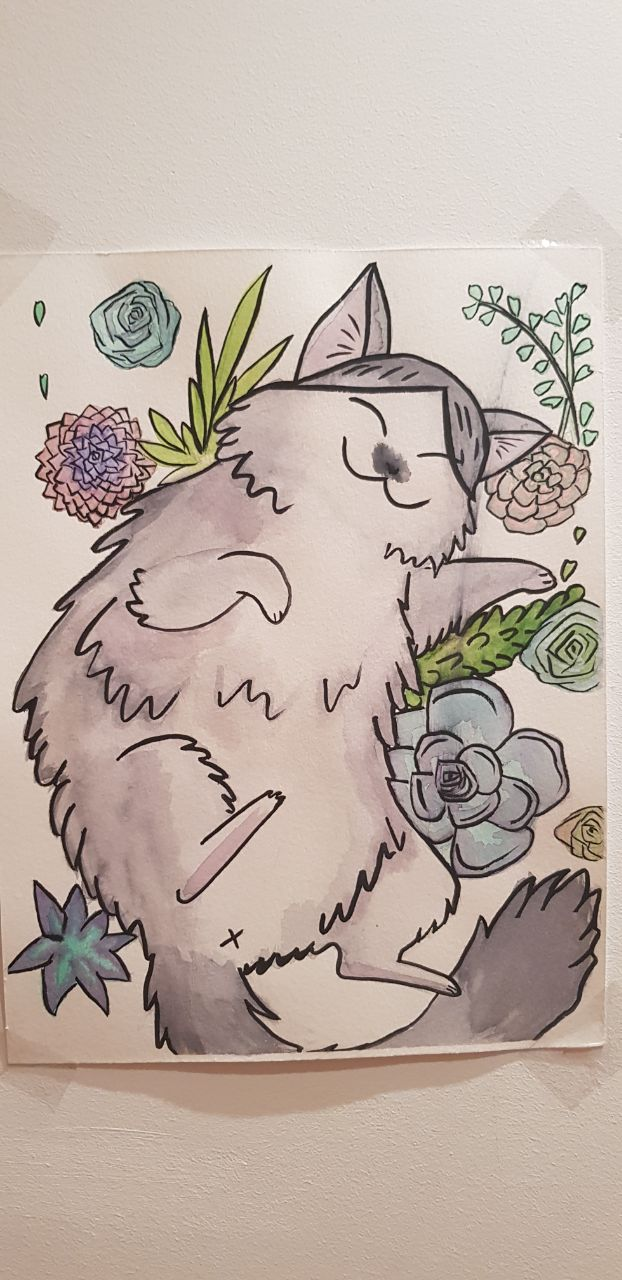

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**